In [22]:
__author__ = 'Dan Suson <djsuson@fnal.gov>' # single string; emails in <>
__version__ = '20210623' # yyyymmdd; version datestamp of this notebook
__datasets__ = ['delve_dr1','gaia_edr3']  # datasets used in this notebook; for available datasets, see cell "Available datasets in Data Lab" further below
__keywords__ = [''], # keywords relevant to this notebook, e.g. ['science case','dwarf galaxies'] Use only keywords from the master list: https://github.com/noaodatalab/notebooks-latest/blob/master/internal/keywords.txt

In [23]:
# std lib
from getpass import getpass

# 3rd party # remove imports that are not needed
import numpy as np
import pylab as plt
import matplotlib
import healpy as hp
import pandas as pd
%matplotlib inline

# Data Lab
from dl import authClient as ac, queryClient as qc, storeClient as sc

In [24]:
# set up variable values to use in analysis
areas = [[-20,-10,120,135], [-30,-20,195,210],[-30,-20,105,120]]
bands = ['g', 'r', 'i', 'z']
lower_spread_limit = -0.025
upper_spread_limit = 0.045
lower_mag_limit = -10
upper_mag_limit = 26
min_spread = 0.003
wide_spread = 0.005
skim = 100

In [25]:
def get_data(area):
  # getting necessary columns from DELVE within a certain RA and DEC
  sql_delve =\
  '''
  SELECT quick_object_id,
  spread_model_g,spreaderr_model_g,mag_auto_g,magerr_auto_g,
  spread_model_r,spreaderr_model_r,mag_auto_r,magerr_auto_r,
  spread_model_i,spreaderr_model_i,mag_auto_i,magerr_auto_i,
  spread_model_z,spreaderr_model_z,mag_auto_z,magerr_auto_z
  FROM delve_dr1.objects
  WHERE dec>{:f} and dec<{:f} and ra>{:f} and ra<{:f}
  '''.format(area[0],area[1],area[2],area[3])
  df1 = qc.query(sql=sql_delve,fmt='pandas')

  # getting all objects from similar patch of sky from gaia x delve data
  sql_gaia =\
  '''
  SELECT *
  FROM gaia_edr3.x1p5__gaia_source__delve_dr1__objects
  WHERE dec1>{:f} and dec1<{:f} and ra1>{:f} and ra1<{:f}
  '''.format(area[0],area[1],area[2],area[3])
  df2 = qc.query(sql=sql_gaia,fmt='pandas')
    
  return df1, df2

In [26]:
def single_band():
  # Loop over single observation bands
  for band in bands:

    # convert to np arrays
    indices = (delve_df[f'mag_auto_{band}'] > lower_mag_limit) & (delve_df[f'mag_auto_{band}'] < upper_mag_limit) \
            & (delve_df[f'spread_model_{band}'] > lower_spread_limit) & (delve_df[f'spread_model_{band}'] < upper_spread_limit)
    quick_object_id = np.array(delve_df['quick_object_id'][indices])
    mag_auto = np.array(delve_df[f'mag_auto_{band}'][indices])
    spread_model = np.array(delve_df[f'spread_model_{band}'][indices])
    spreaderr_model = np.array(delve_df[f'spreaderr_model_{band}'][indices])
    matches = np.isin(quick_object_id,ids)

    #calculate extended class value
    three_sigma_extension = ((delve_df[f'spread_model_{band}'][indices]).values + 3*(delve_df[f'spreaderr_model_{band}'][indices]).values) > wide_spread
    one_sigma_extension = ((delve_df[f'spread_model_{band}'][indices]).values + (delve_df[f'spreaderr_model_{band}'][indices]).values) > min_spread
    bigger_than_PSF = ((delve_df[f'spread_model_{band}'][indices]).values - (delve_df[f'spreaderr_model_{band}'][indices]).values) > min_spread
   
    extended_class = three_sigma_extension.astype(np.int16) + one_sigma_extension.astype(np.int16) + bigger_than_PSF.astype(np.int16)
    extended_class_match = extended_class[matches]

    # getting the magnitudes/spreads of objects that are matched with gaia
    gaia_mags = delve_df[f'mag_auto_{band}'][indices][matches]
    gaia_spreads = delve_df[f'spread_model_{band}'][indices][matches]
    galaxy_ids = np.array(delve_df['quick_object_id'][indices][matches][extended_class_match>1])
    galaxy_matches = np.isin(galaxy_ids,ids)
    def_galaxy_ids = np.array(delve_df['quick_object_id'][indices][matches][extended_class_match>2])
    def_galaxy_matches = np.isin(def_galaxy_ids,ids)

    # print fractional overlap
    print(f'Number of objects in Delve catalog for band {band}: ',len(spread_model))
    print(f'Number of objects/galaxies/definite galaxies in gaia catalog for band {band}: ',len(gaia_spreads),'/',len(galaxy_matches),'/',len(def_galaxy_matches))
    print(f'fraction of objects/galaxies/definite galaxies in gaia catalog for band {band}: %6.4f/%6.4f/%6.4f' \
            % (len(gaia_spreads)/len(spread_model), len(galaxy_matches)/len(spread_model), len(def_galaxy_matches)/len(spread_model)))

    # plot stars verses galaxies
    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(7,7))
    fig.suptitle(f'data for {band} channel')
    ax1.scatter(mag_auto[::skim], spread_model[::skim], c=extended_class[::skim], cmap='bwr', vmin=0, vmax=3, s=1)
    ax1.set_xlabel('mag_auto')
    ax1.set_ylabel('spread_model')
    ax1.set_title(f'extended_class')
    ax1.set_xlim([13.5,26])
    ax1.set_ylim([-0.025,0.045])

    # plott the matches with GAIA
    ax2.scatter(mag_auto[::skim], spread_model[::skim], c='purple', s=1, label='unmatched points')
    ax2.scatter(gaia_mags[::skim], gaia_spreads[::skim], c='teal', s=1, label='matched points')
    ax2.set_xlabel('mag_auto')
    ax2.set_ylabel('spread_model')
    ax2.set_title(f'matching with GAIA')
    ax2.set_xlim([13.5,26])
    ax2.set_ylim([-0.025,0.045])
    ax2.legend(loc='best')

In [27]:
def dual_bands():
  # Loop over two observation bands combined
  for band1 in bands:
    for band2 in bands:
      if band2 > band1:

        # convert to np arrays
        indices = (delve_df[f'mag_auto_{band1}'] > lower_mag_limit) & (delve_df[f'mag_auto_{band1}'] < upper_mag_limit) \
                & (delve_df[f'spread_model_{band1}'] > lower_spread_limit) & (delve_df[f'spread_model_{band1}'] < upper_spread_limit) \
                & (delve_df[f'mag_auto_{band2}'] > lower_mag_limit) & (delve_df[f'mag_auto_{band2}'] < upper_mag_limit) \
                & (delve_df[f'spread_model_{band2}'] > lower_spread_limit) & (delve_df[f'spread_model_{band2}'] < upper_spread_limit)
        quick_object_id = np.array(delve_df['quick_object_id'][indices])
        mag_auto = np.array(delve_df[f'mag_auto_{band1}'][indices])
        spread_model = np.array(delve_df[f'spread_model_{band1}'][indices])
        spreaderr_model = np.array(delve_df[f'spreaderr_model_{band1}'][indices])
        matches = np.isin(quick_object_id,ids)

        #calculate extended class value
        three_sigma_extension_band1 = ((delve_df[f'spread_model_{band1}'][indices]).values + 3*(delve_df[f'spreaderr_model_{band1}'][indices]).values) > wide_spread
        one_sigma_extension_band1 = ((delve_df[f'spread_model_{band1}'][indices]).values + (delve_df[f'spreaderr_model_{band1}'][indices]).values) > min_spread
        bigger_than_PSF_band1 = ((delve_df[f'spread_model_{band1}'][indices]).values - (delve_df[f'spreaderr_model_{band1}'][indices]).values) > min_spread
        three_sigma_extension_band2 = ((delve_df[f'spread_model_{band2}'][indices]).values + 3*(delve_df[f'spreaderr_model_{band2}'][indices]).values) > wide_spread
        one_sigma_extension_band2 = ((delve_df[f'spread_model_{band2}'][indices]).values + (delve_df[f'spreaderr_model_{band2}'][indices]).values) > min_spread
        bigger_than_PSF_band2 = ((delve_df[f'spread_model_{band2}'][indices]).values - (delve_df[f'spreaderr_model_{band2}'][indices]).values) > min_spread
   
        extended_class_band1 = three_sigma_extension_band1.astype(np.int16) + one_sigma_extension_band1.astype(np.int16) + bigger_than_PSF_band1.astype(np.int16)
        extended_class_band2 = three_sigma_extension_band2.astype(np.int16) + one_sigma_extension_band2.astype(np.int16) + bigger_than_PSF_band2.astype(np.int16)
        extended_class_all = np.array([extended_class_band1,extended_class_band2])
        extended_class = np.min(extended_class_all,axis=0)
        extended_class_match = extended_class[matches]
    
        # getting the magnitudes/spreads of objects that are matched with gaia
        gaia_mags = delve_df[f'mag_auto_{band1}'][indices][matches]
        gaia_spreads = delve_df[f'spread_model_{band1}'][indices][matches]
        galaxy_ids = np.array(delve_df['quick_object_id'][indices][matches][extended_class_match>1])
        galaxy_matches = np.isin(galaxy_ids,ids)
        def_galaxy_ids = np.array(delve_df['quick_object_id'][indices][matches][extended_class_match>2])
        def_galaxy_matches = np.isin(def_galaxy_ids,ids)

        # print fractional overlap
        print(f'Number of objects in Delve catalog for band {band1}{band2}: ',len(spread_model))
        print(f'Number of objects/galaxies/definite galaxies in gaia catalog for band {band1}{band2}: ',len(gaia_spreads),'/',len(galaxy_matches),'/',len(def_galaxy_matches))
        print(f'fraction of objects/galaxies/definite galaxies in gaia catalog for band {band1}{band2}: %6.4f/%6.4f/%6.4f' \
              % (len(gaia_spreads)/len(spread_model), len(galaxy_matches)/len(spread_model), len(def_galaxy_matches)/len(spread_model)))

        # plot stars verses galaxies
        fig, (ax1, ax2) = plt.subplots(1,2,figsize=(7,7))
        fig.suptitle(f'data for {band1}{band2} channels')
        ax1.scatter(mag_auto[::100], spread_model[::skim], c=extended_class[::skim], cmap='bwr', vmin=0, vmax=3, s=1)
        ax1.set_xlabel('mag_auto')
        ax1.set_ylabel('spread_model')
        ax1.set_title(f'extended_class')
        ax1.set_xlim([13.5,26])
        ax1.set_ylim([-0.025,0.045])

        # plott the matches with GAIA
        ax2.scatter(mag_auto[::skim], spread_model[::skim], c='purple', s=1, label='unmatched points')
        ax2.scatter(gaia_mags[::skim], gaia_spreads[::skim], c='teal', s=1, label='matched points')
        ax2.set_xlabel('mag_auto')
        ax2.set_ylabel('spread_model')
        ax2.set_title(f'matching with GAIA')
        ax2.set_xlim([13.5,26])
        ax2.set_ylim([-0.025,0.045])
        ax2.legend(loc='best')

In [28]:
def triple_bands():
  # Loop over three observation bands combined
  for band1 in bands:
    for band2 in bands:
      for band3 in bands:
        if band2 > band1:
          if band3 > band2:

            # convert to np arrays
            indices = (delve_df[f'mag_auto_{band1}'] > lower_mag_limit) & (delve_df[f'mag_auto_{band1}'] < upper_mag_limit) \
                    & (delve_df[f'spread_model_{band1}'] > lower_spread_limit) & (delve_df[f'spread_model_{band1}'] < upper_spread_limit) \
                    & (delve_df[f'mag_auto_{band2}'] > lower_mag_limit) & (delve_df[f'mag_auto_{band2}'] < upper_mag_limit) \
                    & (delve_df[f'spread_model_{band2}'] > lower_spread_limit) & (delve_df[f'spread_model_{band2}'] < upper_spread_limit) \
                    & (delve_df[f'mag_auto_{band3}'] > lower_mag_limit) & (delve_df[f'mag_auto_{band3}'] < upper_mag_limit) \
                    & (delve_df[f'spread_model_{band3}'] > lower_spread_limit) & (delve_df[f'spread_model_{band3}'] < upper_spread_limit)
            quick_object_id = np.array(delve_df['quick_object_id'][indices])
            mag_auto = np.array(delve_df[f'mag_auto_{band1}'][indices])
            spread_model = np.array(delve_df[f'spread_model_{band1}'][indices])
            spreaderr_model = np.array(delve_df[f'spreaderr_model_{band1}'][indices])
            matches = np.isin(quick_object_id,ids)

            #calculate extended class value
            three_sigma_extension_band1 = ((delve_df[f'spread_model_{band1}'][indices]).values + 3*(delve_df[f'spreaderr_model_{band1}'][indices]).values) > wide_spread
            one_sigma_extension_band1 = ((delve_df[f'spread_model_{band1}'][indices]).values + (delve_df[f'spreaderr_model_{band1}'][indices]).values) > min_spread
            bigger_than_PSF_band1 = ((delve_df[f'spread_model_{band1}'][indices]).values - (delve_df[f'spreaderr_model_{band1}'][indices]).values) > min_spread
            three_sigma_extension_band2 = ((delve_df[f'spread_model_{band2}'][indices]).values + 3*(delve_df[f'spreaderr_model_{band2}'][indices]).values) > wide_spread
            one_sigma_extension_band2 = ((delve_df[f'spread_model_{band2}'][indices]).values + (delve_df[f'spreaderr_model_{band2}'][indices]).values) > min_spread
            bigger_than_PSF_band2 = ((delve_df[f'spread_model_{band2}'][indices]).values - (delve_df[f'spreaderr_model_{band2}'][indices]).values) > min_spread
            three_sigma_extension_band3 = ((delve_df[f'spread_model_{band3}'][indices]).values + 3*(delve_df[f'spreaderr_model_{band3}'][indices]).values) > wide_spread
            one_sigma_extension_band3 = ((delve_df[f'spread_model_{band3}'][indices]).values + (delve_df[f'spreaderr_model_{band3}'][indices]).values) > min_spread
            bigger_than_PSF_band3 = ((delve_df[f'spread_model_{band3}'][indices]).values - (delve_df[f'spreaderr_model_{band3}'][indices]).values) > min_spread
  
            extended_class_band1 = three_sigma_extension_band1.astype(np.int16) + one_sigma_extension_band1.astype(np.int16) + bigger_than_PSF_band1.astype(np.int16)
            extended_class_band2 = three_sigma_extension_band2.astype(np.int16) + one_sigma_extension_band2.astype(np.int16) + bigger_than_PSF_band2.astype(np.int16)
            extended_class_band3 = three_sigma_extension_band3.astype(np.int16) + one_sigma_extension_band3.astype(np.int16) + bigger_than_PSF_band3.astype(np.int16)
            extended_class_all = np.array([extended_class_band1, extended_class_band2, extended_class_band3])
            extended_class = np.min(extended_class_all,axis=0)
            extended_class_match = extended_class[matches]

            # getting the magnitudes/spreads of objects that are matched with gaia
            gaia_mags = delve_df[f'mag_auto_{band1}'][indices][matches]
            gaia_spreads = delve_df[f'spread_model_{band1}'][indices][matches]
            galaxy_ids = np.array(delve_df['quick_object_id'][indices][matches][extended_class_match>1])
            galaxy_matches = np.isin(galaxy_ids,ids)
            def_galaxy_ids = np.array(delve_df['quick_object_id'][indices][matches][extended_class_match>2])
            def_galaxy_matches = np.isin(def_galaxy_ids,ids)

            # print fractional overlap
            print(f'Number of objects in Delve catalog for band {band1}{band2}{band3}: ',len(spread_model))
            print(f'Number of objects/galaxies/definite galaxies in gaia catalog for band {band1}{band2}{band3}: ',len(gaia_spreads),'/',len(galaxy_matches),'/',len(def_galaxy_matches))
            print(f'fraction of objects/galaxies/definite galaxies in gaia catalog for band {band1}{band2}{band3}: %6.4f/%6.4f/%6.4f' \
                  % (len(gaia_spreads)/len(spread_model), len(galaxy_matches)/len(spread_model), len(def_galaxy_matches)/len(spread_model)))

            # plot stars verses galaxies
            fig, (ax1, ax2) = plt.subplots(1,2,figsize=(7,7))
            fig.suptitle(f'data for {band1}{band2}{band3} channels')
            ax1.scatter(mag_auto[::skim], spread_model[::skim], c=extended_class[::skim], cmap='bwr', vmin=0, vmax=3, s=1)
            ax1.set_xlabel('mag_auto')
            ax1.set_ylabel('spread_model')
            ax1.set_title(f'extended_class')
            ax1.set_xlim([13.5,26])
            ax1.set_ylim([-0.025,0.045])

            # plott the matches with GAIA
            ax2.scatter(mag_auto[::skim], spread_model[::skim], c='purple', s=1, label='unmatched points')
            ax2.scatter(gaia_mags[::skim], gaia_spreads[::skim], c='teal', s=1, label='matched points')
            ax2.set_xlabel('mag_auto')
            ax2.set_ylabel('spread_model')
            ax2.set_title(f'matching with GAIA')
            ax2.set_xlim([13.5,26])
            ax2.set_ylim([-0.025,0.045])
            ax2.legend(loc='best')

In [29]:
def quadruple_bands():
  # Look at all four bands combined

  # convert to np arrays
  indices = (delve_df['mag_auto_g'] > lower_mag_limit) & (delve_df['mag_auto_g'] < upper_mag_limit) \
          & (delve_df['spread_model_g']<upper_limit) & (delve_df['spread_model_g']>lower_limit) \
          & (delve_df['mag_auto_r'] > lower_mag_limit) & (delve_df['mag_auto_r'] < upper_mag_limit) \
          & (delve_df['spread_model_r']<upper_limit) & (delve_df['spread_model_r']>lower_limit) \
          & (delve_df['mag_auto_i'] > lower_mag_limit) & (delve_df['mag_auto_i'] < upper_mag_limit) \
          & (delve_df['spread_model_i']<upper_limit) & (delve_df['spread_model_i']>lower_limit) \
          & (delve_df['mag_auto_z'] > lower_mag_limit) & (delve_df['mag_auto_z'] < upper_mag_limit) \
          & (delve_df['spread_model_z']<upper_limit) & (delve_df['spread_model_z']>lower_limit)
  quick_object_id = np.array(delve_df['quick_object_id'][indices])
  mag_auto = np.array(delve_df['mag_auto_g'][indices])
  spread_model = np.array(delve_df['spread_model_g'][indices])
  spreaderr_model = np.array(delve_df['spreaderr_model_g'][indices])
  matches = np.isin(quick_object_id,ids)

  #calculate extended class value
  three_sigma_extension_g = ((delve_df['spread_model_g'][indices]).values + 3*(delve_df['spreaderr_model_g'][indices]).values) > wide_spread
  one_sigma_extension_g = ((delve_df['spread_model_g'][indices]).values + (delve_df['spreaderr_model_g'][indices]).values) > min_spread
  bigger_than_PSF_g = ((delve_df['spread_model_g'][indices]).values - (delve_df['spreaderr_model_g'][indices]).values) > min_spread
  three_sigma_extension_r = ((delve_df['spread_model_r'][indices]).values + 3*(delve_df['spreaderr_model_r'][indices]).values) > wide_spread
  one_sigma_extension_r = ((delve_df['spread_model_r'][indices]).values + (delve_df['spreaderr_model_r'][indices]).values) > min_spread
  bigger_than_PSF_r = ((delve_df['spread_model_r'][indices]).values - (delve_df['spreaderr_model_r'][indices]).values) > min_spread
  three_sigma_extension_i = ((delve_df['spread_model_i'][indices]).values + 3*(delve_df['spreaderr_model_i'][indices]).values) > wide_spread
  one_sigma_extension_i = ((delve_df['spread_model_i'][indices]).values + (delve_df['spreaderr_model_i'][indices]).values) > min_spread
  bigger_than_PSF_i = ((delve_df['spread_model_i'][indices]).values - (delve_df['spreaderr_model_i'][indices]).values) > min_spread
  three_sigma_extension_z = ((delve_df['spread_model_z'][indices]).values + 3*(delve_df['spreaderr_model_z'][indices]).values) > wide_spread
  one_sigma_extension_z = ((delve_df['spread_model_z'][indices]).values + (delve_df['spreaderr_model_z'][indices]).values) > min_spread
  bigger_than_PSF_z = ((delve_df['spread_model_z'][indices]).values - (delve_df['spreaderr_model_z'][indices]).values) > min_spread
   
  extended_class_g = three_sigma_extension_g.astype(np.int16) + one_sigma_extension_g.astype(np.int16) + bigger_than_PSF_g.astype(np.int16)
  extended_class_r = three_sigma_extension_r.astype(np.int16) + one_sigma_extension_r.astype(np.int16) + bigger_than_PSF_r.astype(np.int16)
  extended_class_i = three_sigma_extension_i.astype(np.int16) + one_sigma_extension_i.astype(np.int16) + bigger_than_PSF_i.astype(np.int16)
  extended_class_z = three_sigma_extension_z.astype(np.int16) + one_sigma_extension_z.astype(np.int16) + bigger_than_PSF_z.astype(np.int16)
  extended_class_all = np.array([extended_class_g, extended_class_r, extended_class_i, extended_class_z])
  extended_class = np.min(extended_class_all,axis=0)
  extended_class_match = extended_class[matches]

  # getting the magnitudes/spreads of objects that are matched with gaia
  gaia_mags = delve_df['mag_auto_g'][indices][matches]
  gaia_spreads = delve_df['spread_model_g'][indices][matches]
  galaxy_ids = np.array(delve_df['quick_object_id'][indices][matches][extended_class_match>1])
  galaxy_matches = np.isin(galaxy_ids,ids)
  def_galaxy_ids = np.array(delve_df['quick_object_id'][indices][extended_class>2])
  def_galaxy_matches = np.isin(def_galaxy_ids,ids)

  # print fractional overlap
  print('Number of objects in Delve catalog for band griz: ',len(spread_model))
  print('Number of objects/galaxies/definite galaxies in gaia catalog for band griz: ',len(gaia_spreads),'/',len(galaxy_matches),'/',len(def_galaxy_matches))
  print('fraction of objects/galaxies/definite galaxies in gaia catalog for band griz: %6.4f/%6.4f/%6.4f' \
        % (len(gaia_spreads)/len(spread_model), len(galaxy_matches)/len(spread_model), len(def_galaxy_matches)/len(spread_model)))

  # plot stars verses galaxies
  fig, (ax1, ax2) = plt.subplots(1,2,figsize=(7,7))
  fig.suptitle('data for griz channels')
  ax1.scatter(mag_auto[::100], spread_model[::skim], c=extended_class[::skim], cmap='bwr', vmin=0, vmax=3, s=1)
  ax1.set_xlabel('mag_auto')
  ax1.set_ylabel('spread_model')
  ax1.set_title('extended_class')
  ax1.set_xlim([13.5,26])
  ax1.set_ylim([-0.025,0.045])

  # plott the matches with GAIA
  ax2.scatter(mag_auto[::skim], spread_model[::skim], c='purple', s=1, label='unmatched points')
  ax2.scatter(gaia_mags[::skim], gaia_spreads[::skim], c='teal', s=1, label='matched points')
  ax2.set_xlabel('mag_auto')
  ax2.set_ylabel('spread_model')
  ax2.set_title('matching with GAIA')
  ax2.set_xlim([13.5,26])
  ax2.set_ylim([-0.025,0.045])
  ax2.legend(loc='best')

Analyzing area -20 < dec < -10, 120 < RA < 135
Number of objects in Delve catalog for band g:  5373634
Number of objects/galaxies/definite galaxies in gaia catalog for band g:  2457582 / 158033 / 56863
fraction of objects/galaxies/definite galaxies in gaia catalog for band g: 0.4573/0.0294/0.0106
Number of objects in Delve catalog for band r:  6506028
Number of objects/galaxies/definite galaxies in gaia catalog for band r:  2477001 / 91662 / 61747
fraction of objects/galaxies/definite galaxies in gaia catalog for band r: 0.3807/0.0141/0.0095
Number of objects in Delve catalog for band i:  5434106
Number of objects/galaxies/definite galaxies in gaia catalog for band i:  1731677 / 55420 / 43819
fraction of objects/galaxies/definite galaxies in gaia catalog for band i: 0.3187/0.0102/0.0081
Number of objects in Delve catalog for band z:  7580274
Number of objects/galaxies/definite galaxies in gaia catalog for band z:  2472185 / 100845 / 67552
fraction of objects/galaxies/definite galaxies 

/data0/sw/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Number of objects in Delve catalog for band gz:  3453182
Number of objects/galaxies/definite galaxies in gaia catalog for band gz:  1122039 / 40444 / 37502
fraction of objects/galaxies/definite galaxies in gaia catalog for band gz: 0.3249/0.0117/0.0109
Number of objects in Delve catalog for band rz:  4571130
Number of objects/galaxies/definite galaxies in gaia catalog for band rz:  1070229 / 40162 / 37431
fraction of objects/galaxies/definite galaxies in gaia catalog for band rz: 0.2341/0.0088/0.0082
Number of objects in Delve catalog for band ir:  4641557
Number of objects/galaxies/definite galaxies in gaia catalog for band ir:  940551 / 34905 / 32633
fraction of objects/galaxies/definite galaxies in gaia catalog for band ir: 0.2026/0.0075/0.0070
Number of objects in Delve catalog for band iz:  4613655
Number of objects/galaxies/definite galaxies in gaia catalog for band iz:  999876 / 39566 / 36256
fraction of objects/galaxies/definite galaxies in gaia catalog for band iz: 0.2167/0.00

/data0/sw/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Number of objects in Delve catalog for band gir:  3060222
Number of objects/galaxies/definite galaxies in gaia catalog for band gir:  906110 / 31309 / 29594
fraction of objects/galaxies/definite galaxies in gaia catalog for band gir: 0.2961/0.0102/0.0097
Number of objects in Delve catalog for band giz:  2961333
Number of objects/galaxies/definite galaxies in gaia catalog for band giz:  957564 / 33301 / 31446
fraction of objects/galaxies/definite galaxies in gaia catalog for band giz: 0.3234/0.0112/0.0106
Number of objects in Delve catalog for band irz:  3883339
Number of objects/galaxies/definite galaxies in gaia catalog for band irz:  920357 / 33498 / 31480
fraction of objects/galaxies/definite galaxies in gaia catalog for band irz: 0.2370/0.0086/0.0081
Number of objects in Delve catalog for band griz:  2729098
Number of objects/galaxies/definite galaxies in gaia catalog for band griz:  886932 / 30247 / 723642
fraction of objects/galaxies/definite galaxies in gaia catalog for band gri

/data0/sw/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Analyzing area -30 < dec < -20, 105 < RA < 120
Number of objects in Delve catalog for band g:  263472
Number of objects/galaxies/definite galaxies in gaia catalog for band g:  200526 / 12611 / 3868
fraction of objects/galaxies/definite galaxies in gaia catalog for band g: 0.7611/0.0479/0.0147


/data0/sw/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Number of objects in Delve catalog for band r:  318737
Number of objects/galaxies/definite galaxies in gaia catalog for band r:  195010 / 7909 / 4244
fraction of objects/galaxies/definite galaxies in gaia catalog for band r: 0.6118/0.0248/0.0133
Number of objects in Delve catalog for band i:  303139
Number of objects/galaxies/definite galaxies in gaia catalog for band i:  162122 / 6519 / 3525
fraction of objects/galaxies/definite galaxies in gaia catalog for band i: 0.5348/0.0215/0.0116
Number of objects in Delve catalog for band z:  323527
Number of objects/galaxies/definite galaxies in gaia catalog for band z:  169317 / 8995 / 3950
fraction of objects/galaxies/definite galaxies in gaia catalog for band z: 0.5233/0.0278/0.0122
Number of objects in Delve catalog for band gr:  239899
Number of objects/galaxies/definite galaxies in gaia catalog for band gr:  183800 / 4436 / 2435
fraction of objects/galaxies/definite galaxies in gaia catalog for band gr: 0.7662/0.0185/0.0102
Number of obj

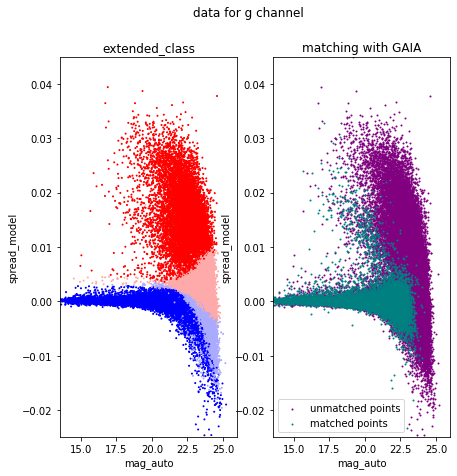

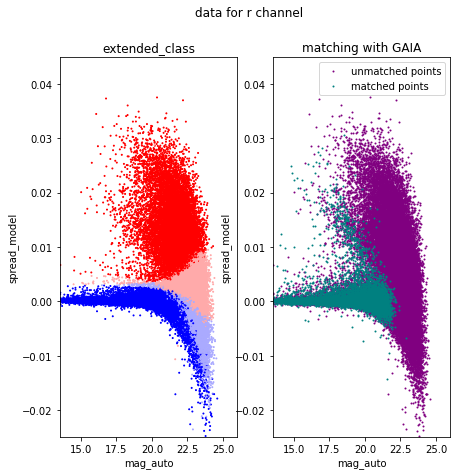

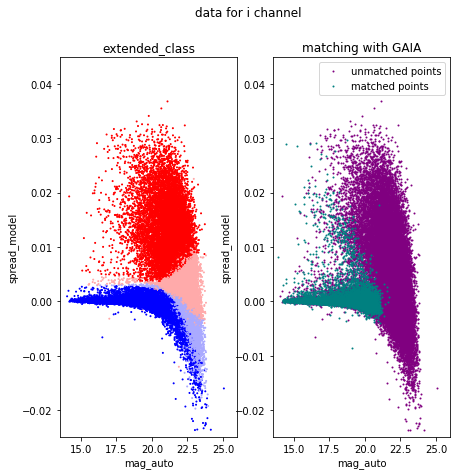

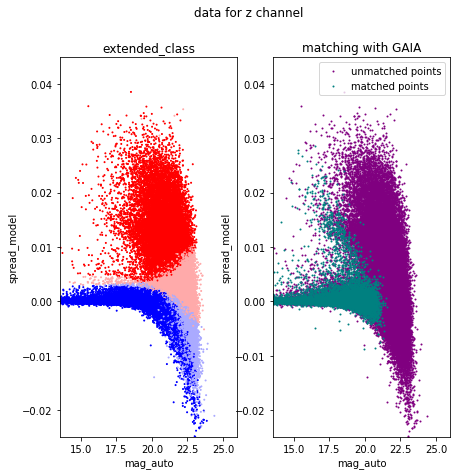

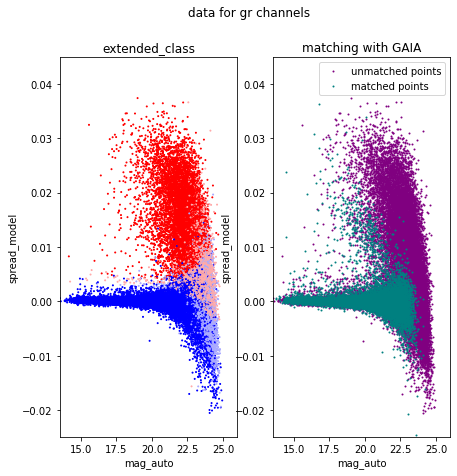

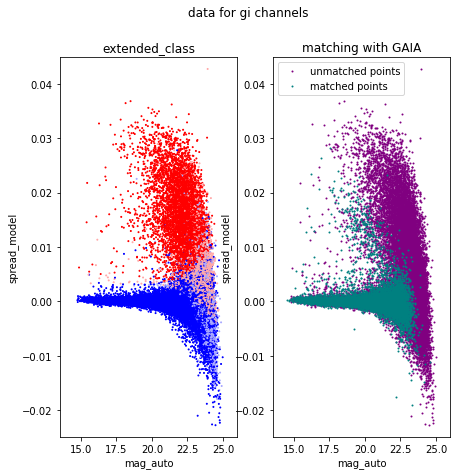

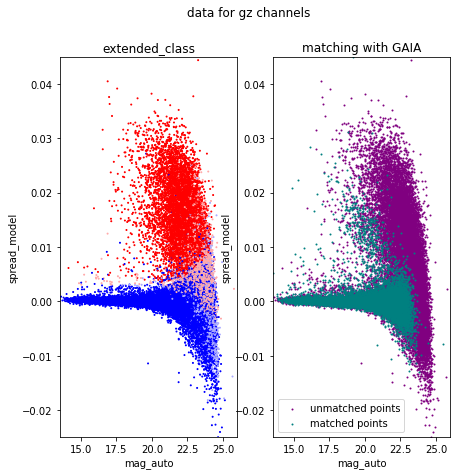

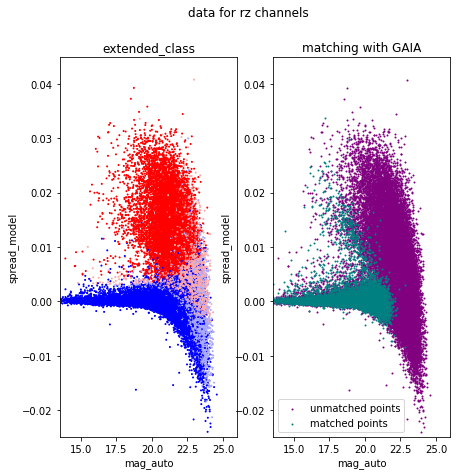

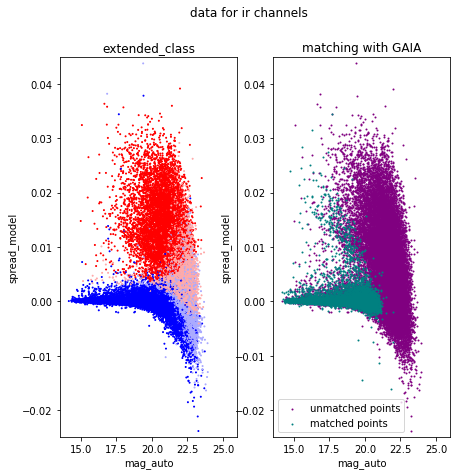

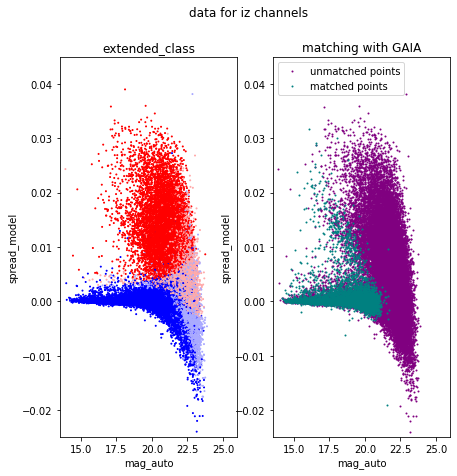

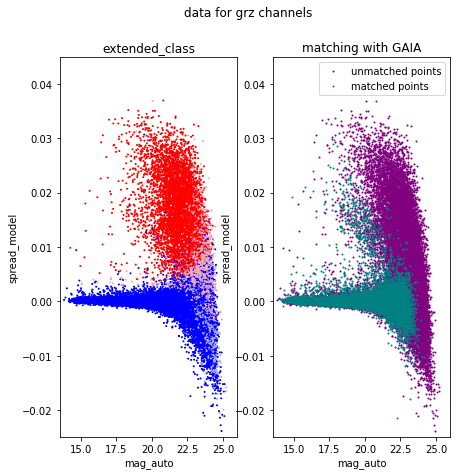

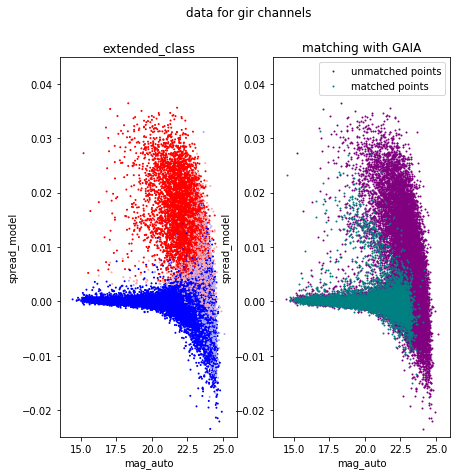

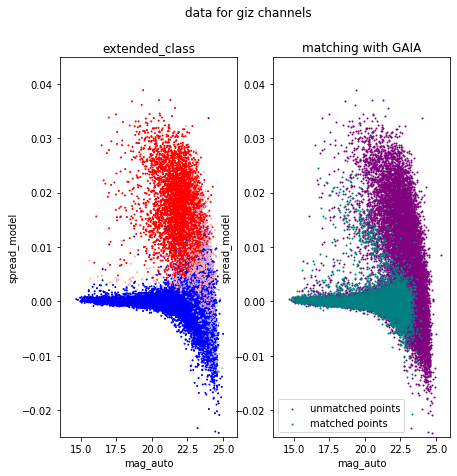

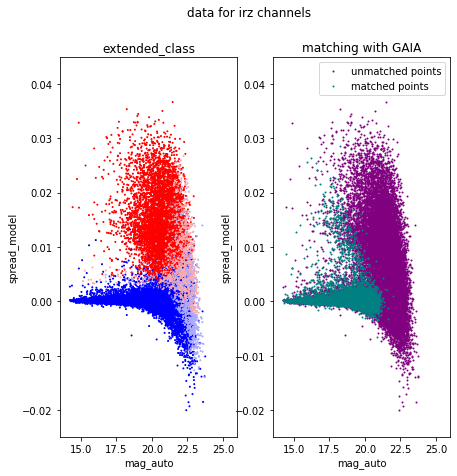

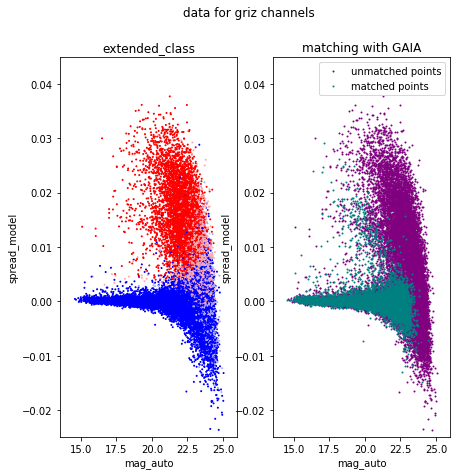

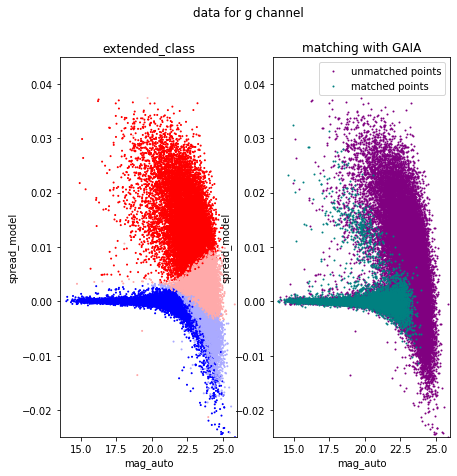

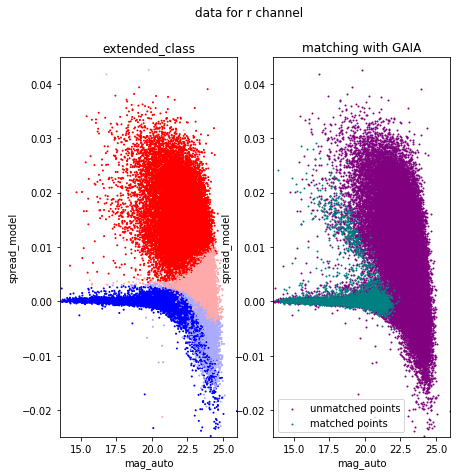

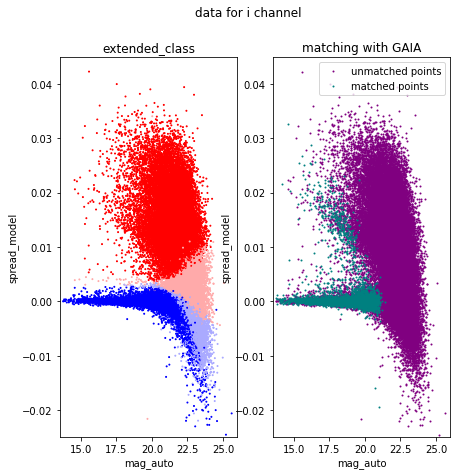

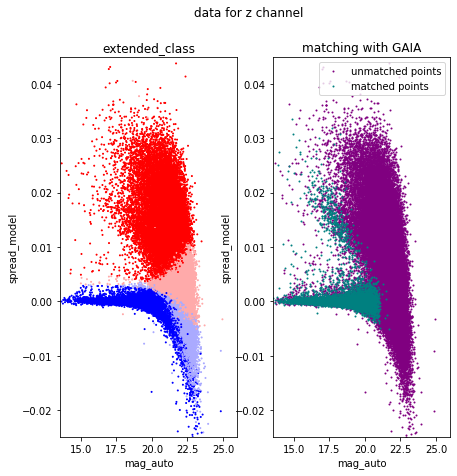

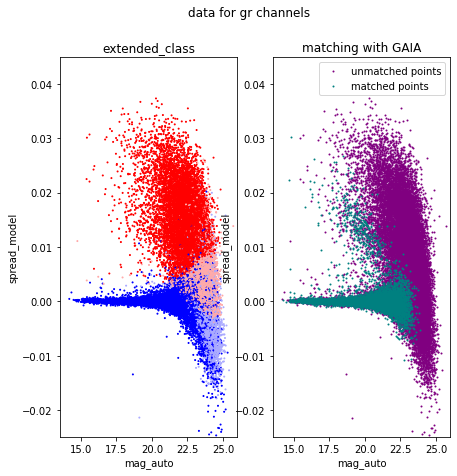

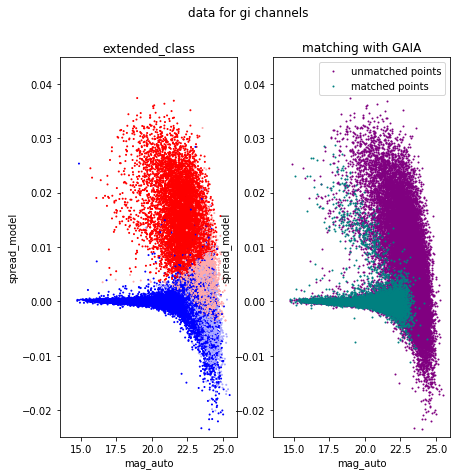

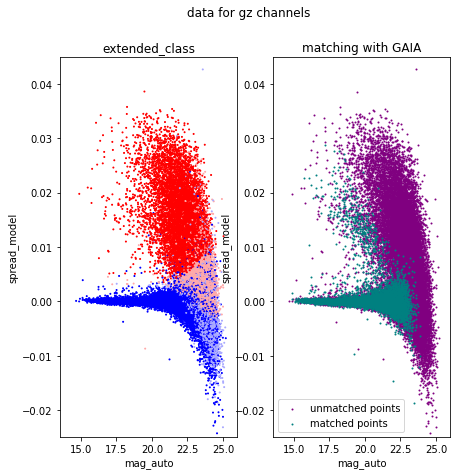

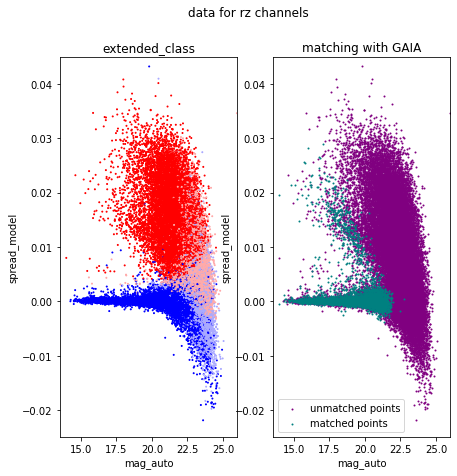

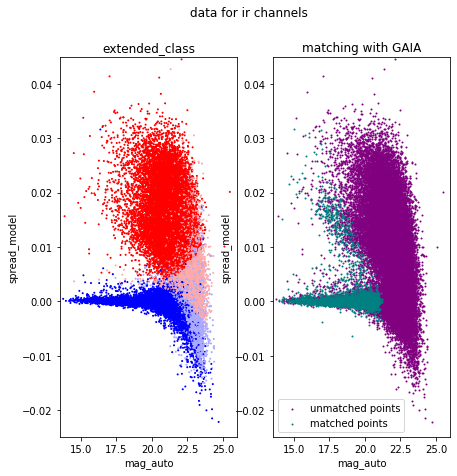

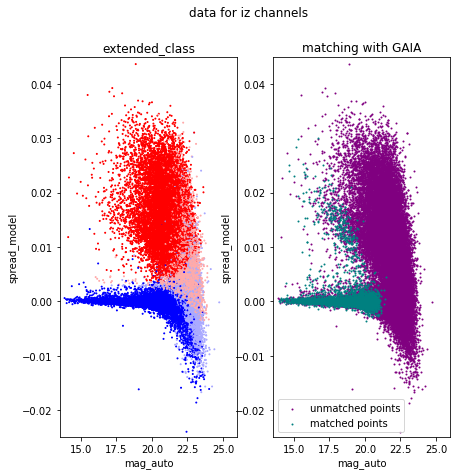

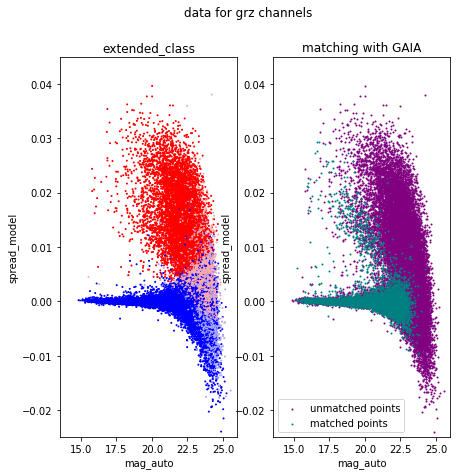

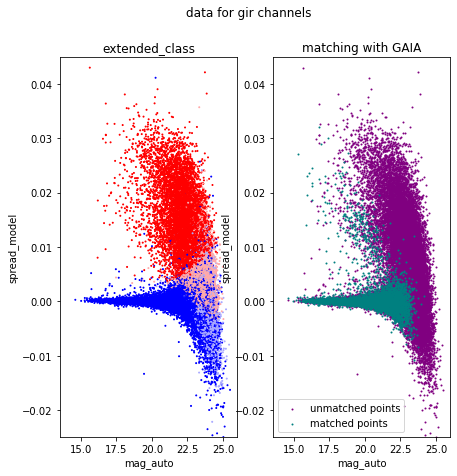

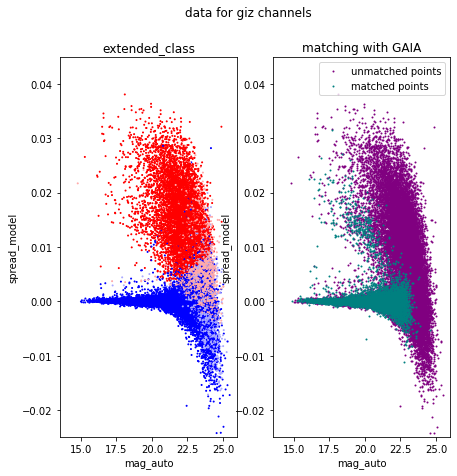

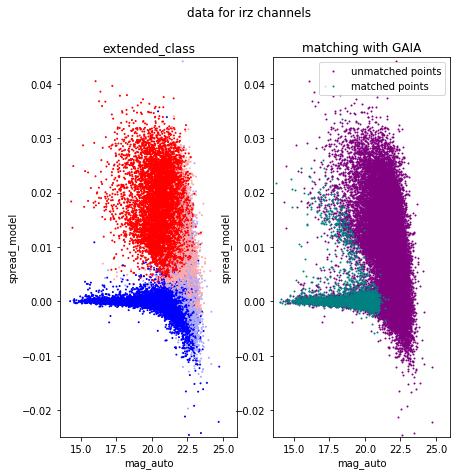

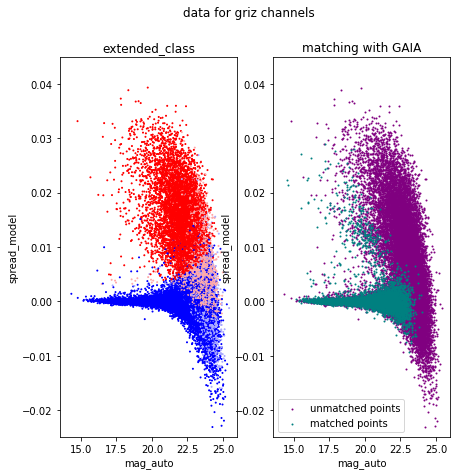

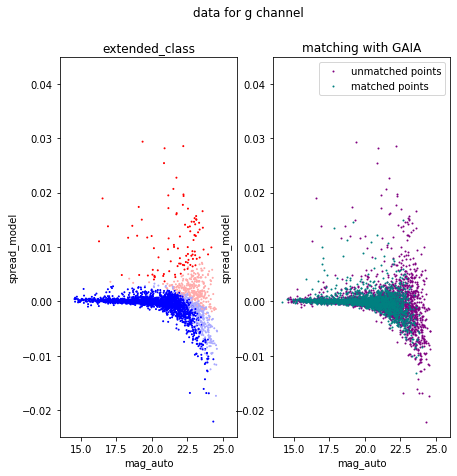

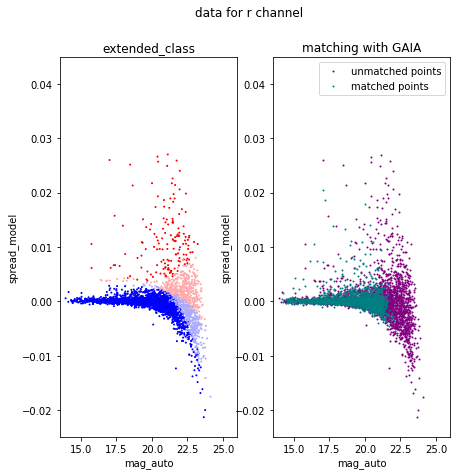

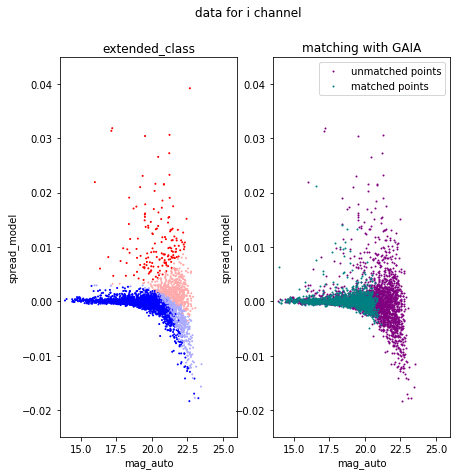

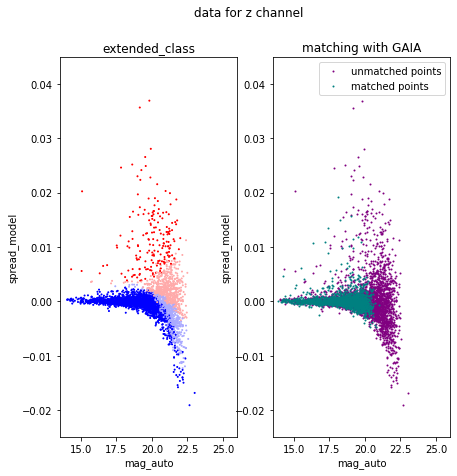

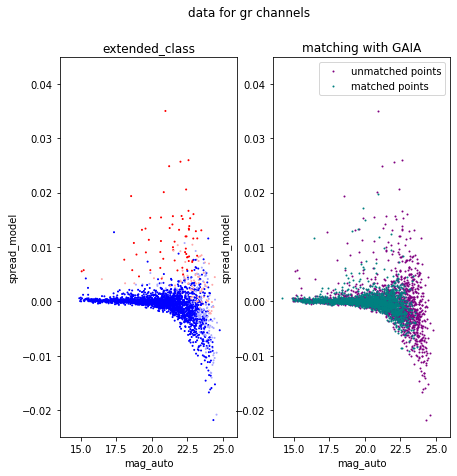

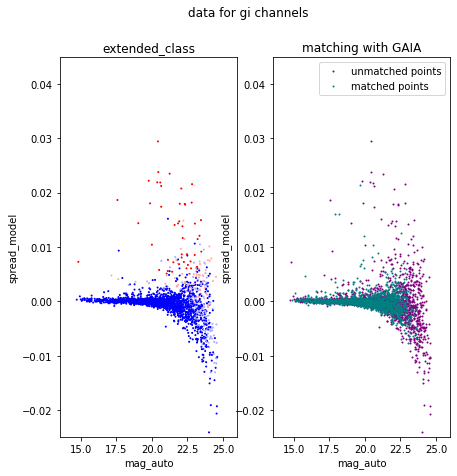

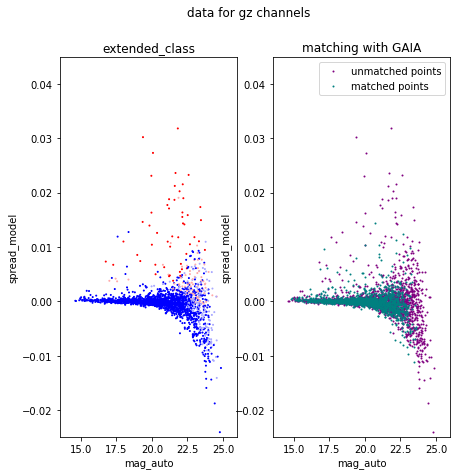

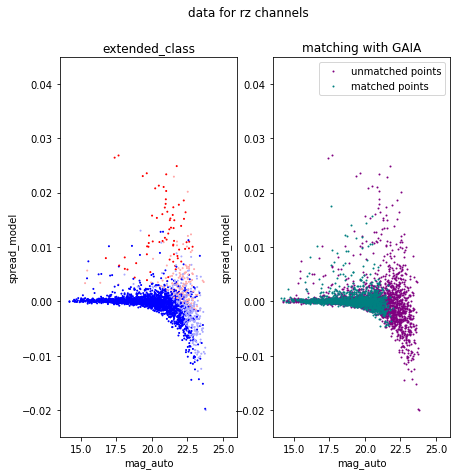

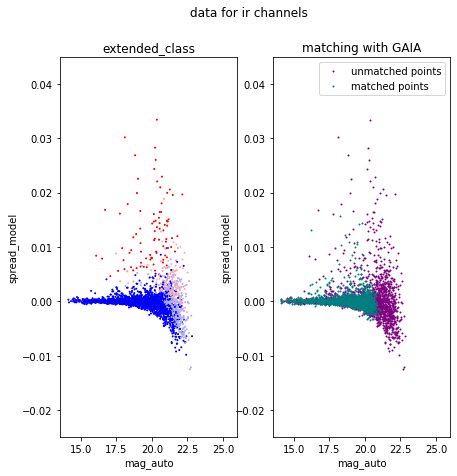

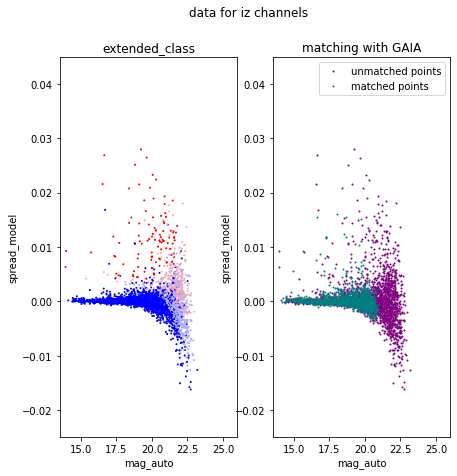

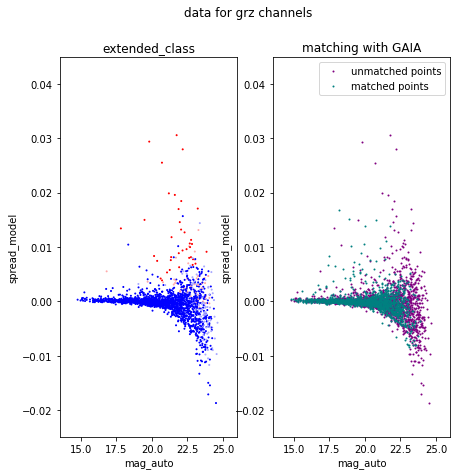

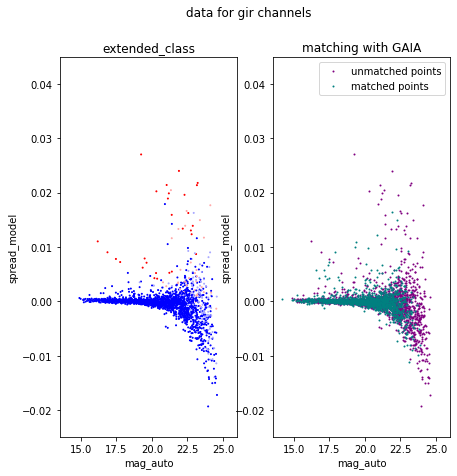

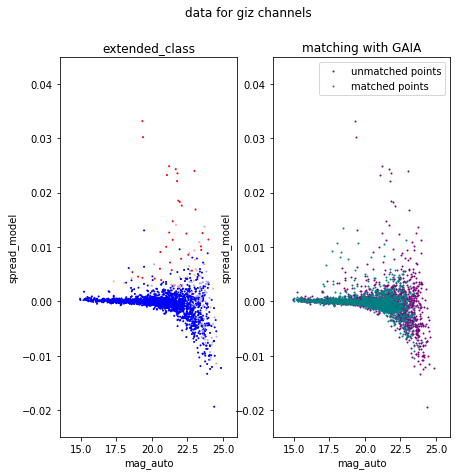

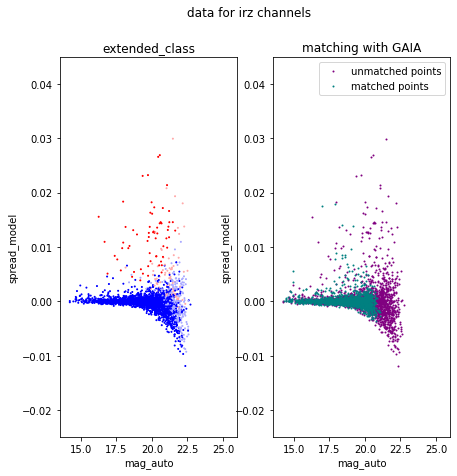

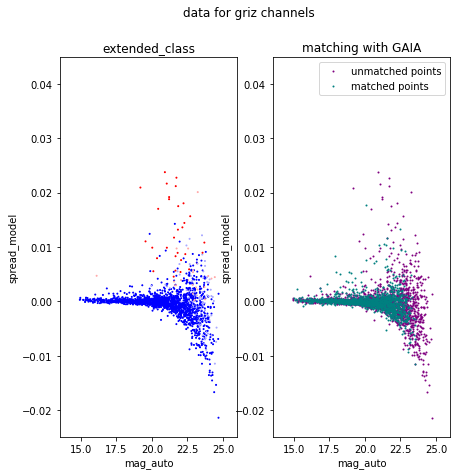

In [30]:
for area in areas:
  delve_df, gaia_df = get_data(area) # get data from databases
  ids = np.array(gaia_df['id2']) # turn Delve IDs in the gaia dataset into an array
  print(f'Analyzing area {area[0]} < dec < {area[1]}, {area[2]} < RA < {area[3]}')
  single_band()
  dual_bands()
  triple_bands()
  quadruple_bands()
  print('')